# NCC (Name-Country Classification) with RNN

## Imports

In [1]:
import sys
import json
sys.path.append('../../')

import numpy as np
import pandas as pd
import argparse
import gzip
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import six.moves.cPickle as pickle

import tvm
from system_level import autodiff as ad
from system_level import tvm_op

import warnings
warnings.filterwarnings("ignore")

## Setup

In [2]:
tgt = "llvm"
tgt_host = "llvm"

# create context object
executor_ctx = tvm.device(tgt, 0)

print_loss_val_each_epoch = True
num_epochs = 20

def convert_to_one_hot(vals):
    """Helper method to convert label array to one-hot array."""
    one_hot_vals = np.zeros((vals.size, 10))
    one_hot_vals[np.arange(vals.size), vals] = 1
    return one_hot_vals


## Load and examine dataset

In [3]:
train_set = pd.read_json('train.jsonl', lines=True)
valid_set = pd.read_json('valid.jsonl', lines=True)
test_set = pd.read_json('test.jsonl', lines=True)

all_letters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"
n_letters = len(all_letters)

dataset = pd.concat([train_set, valid_set, test_set], ignore_index=True)
n_categories = dataset['country'].nunique()
all_categories = dataset['country'].unique()
categ_to_idx = {categ: idx for idx, categ in enumerate(all_categories)}
idx_to_categ = {v: k for k, v in categ_to_idx.items()}

print(categ_to_idx)

{'English': 0, 'Russian': 1, 'Italian': 2, 'German': 3, 'Japanese': 4, 'Dutch': 5, 'Arabic': 6, 'Chinese': 7, 'Greek': 8, 'Czech': 9, 'Irish': 10, 'Spanish': 11, 'French': 12, 'Polish': 13, 'Vietnamese': 14, 'Korean': 15, 'Portuguese': 16, 'Scottish': 17}


In [4]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToNDArray(letter):
    ndarray = np.zeros((1, n_letters), dtype=np.float32)
    ndarray[0][letterToIndex(letter)] = 1
    return ndarray

def lineToTensor(line):
    ndarray = np.zeros((len(line), 1, n_letters), dtype=np.float32)
    for li, letter in enumerate(line):
        ndarray[li][0][letterToIndex(letter)] = 1
    return ndarray

## Construct the computational graph

<img src="../images/rnn.png" width="80%">

In [5]:
print("=== Declaring Weights ===")

U = ad.Variable(name="U") # input to hidden
W = ad.Variable(name="W") # hidden to hidden
b1 = ad.Variable(name="b1") # hidden bias

V = ad.Variable(name="V") # hidden to output
b2 = ad.Variable(name="b2") # output bias

X = ad.Variable(name="X") # input
h_t_1 = ad.Variable(name="h") # hidden state
y_ = ad.Variable(name="y_") # label

=== Declaring Weights ===


In [6]:
print("=== Constructing Computational Graph ===")

z1 = ad.matmul_op(X, U)
z2 = ad.matmul_op(h_t_1, W)
h_t = ad.relu_op(z1 + z2 + ad.broadcastto_op(b1, z1))

z3 = ad.matmul_op(h_t, V)
output = z3 + ad.broadcastto_op(b2, z3)

# softmax & cross entropy
loss = ad.softmaxcrossentropy_op(output, y_)

grad_U, grad_W, grad_b1, grad_V, grad_b2 = ad.gradients(
    loss, [U, W, b1, V, b2])

executor = ad.Executor(
    [loss, grad_U, grad_W, grad_b1, grad_V, grad_b2, h_t, output],
    ctx=executor_ctx)

=== Constructing Computational Graph ===


In [7]:
n_hidden = 128

print("=== Initializing Weights ===")

# Initialize parameters
rand = np.random.RandomState(42)
U_val = rand.normal(scale=0.01, size=(n_letters, n_hidden)).astype(np.float32)
W_val = rand.normal(scale=0.01, size=(n_hidden, n_hidden)).astype(np.float32)
b1_val = rand.normal(scale=0.01, size=(n_hidden)).astype(np.float32)

V_val = rand.normal(scale=0.01, size=(n_hidden, n_categories)).astype(np.float32)
b2_val = rand.normal(scale=0.01, size=(n_categories)).astype(np.float32)

y_val = np.empty(shape=(1, n_categories), dtype=np.float32)
valid_y_val = np.empty(shape=(1, n_categories), dtype=np.float32)
test_y_val = np.empty(shape=(1, n_categories), dtype=np.float32)

# wrap with tvm.nd.array
U_val = tvm.nd.array(U_val)
W_val = tvm.nd.array(W_val)
b1_val = tvm.nd.array(b1_val)
V_val = tvm.nd.array(V_val)
b2_val = tvm.nd.array(b2_val)

y_val = tvm.nd.array(y_val)
valid_y_val = tvm.nd.array(valid_y_val)
test_y_val = tvm.nd.array(test_y_val)

print("deferring X_val and h_t_1_val to runtime...")

=== Initializing Weights ===
deferring X_val and h_t_1_val to runtime...


## Train & Eval

In [8]:
# training loop
lr = 5.0e-3
# JIT compile sgd update ops
U_sgd_update_func = tvm_op.make_sgd_update(
    U_val.shape, lr, tgt, tgt_host, "U_sgd_update")
W_sgd_update_func = tvm_op.make_sgd_update(
    W_val.shape, lr, tgt, tgt_host, "W_sgd_update")
b1_sgd_update_func = tvm_op.make_sgd_update(
    b1_val.shape, lr, tgt, tgt_host, "b1_sgd_update")
V_sgd_update_func = tvm_op.make_sgd_update(
    V_val.shape, lr, tgt, tgt_host, "V_sgd_update")
b2_sgd_update_func = tvm_op.make_sgd_update(
    b2_val.shape, lr, tgt, tgt_host, "b2_sgd_update")

In [9]:
time_measurements = []
train_acc_values = []
val_acc_values = []
loss_values = []

for i in range(num_epochs):
    print(f"***** EPOCH {i+1} *****")
    
    # eval on train set
    train_correct = 0
    train_total = 0
    for _, row in train_set.iterrows():
        category = row["country"]
        line = row["name"]
        category_tensor = np.zeros((1, n_categories), dtype=np.float32)
        category_tensor[0][categ_to_idx[category]] = 1
        line_tensor = lineToTensor(line)
        
        y_val.copyfrom(category_tensor)
        h_t_1_val = np.zeros((1, n_hidden), dtype=np.float32)
        h_t_1_val = tvm.nd.array(h_t_1_val)
        
        for letter_i in range(line_tensor.shape[0]):
            X_val = tvm.nd.array(line_tensor[letter_i])
            _, _, _, _, _, _, h_t_val, y_pred = executor.run(
                feed_dict={
                    X: X_val, 
                    h_t_1: h_t_1_val,
                    y_: y_val, 
                    U: U_val,
                    W: W_val,
                    b1: b1_val,
                    V: V_val,
                    b2: b2_val
                })
            h_t_1_val.copyfrom(h_t_val)
            
        train_correct += int(np.argmax(y_pred.asnumpy()[0]) == np.argmax(category_tensor[0]))
        train_total += 1
    train_acc = train_correct / train_total
    train_acc_values.append(train_acc)
    print("accuracy on train set: ", train_acc)
    
    # eval on valid set
    val_correct = 0
    val_total = 0
    for _, row in valid_set.iterrows():
        category = row["country"]
        line = row["name"]
        category_tensor = np.zeros((1, n_categories), dtype=np.float32)
        category_tensor[0][categ_to_idx[category]] = 1
        line_tensor = lineToTensor(line)
        
        y_val.copyfrom(category_tensor)
        h_t_1_val = np.zeros((1, n_hidden), dtype=np.float32)
        h_t_1_val = tvm.nd.array(h_t_1_val)
        
        for letter_i in range(line_tensor.shape[0]):
            X_val = tvm.nd.array(line_tensor[letter_i])
            _, _, _, _, _, _, h_t_val, y_pred = executor.run(
                feed_dict={
                    X: X_val, 
                    h_t_1: h_t_1_val,
                    y_: y_val, 
                    U: U_val,
                    W: W_val,
                    b1: b1_val,
                    V: V_val,
                    b2: b2_val
                })
            h_t_1_val.copyfrom(h_t_val)
            
        val_correct += int(np.argmax(y_pred.asnumpy()[0]) == np.argmax(category_tensor[0]))
        val_total += 1
    val_acc = val_correct / val_total
    val_acc_values.append(val_acc)
    print("accuracy on valid set: ", val_acc)
    
    # train on train set
    for _, row in train_set.iterrows():
        category = row["country"]
        line = row["name"]
        category_tensor = np.zeros((1, n_categories), dtype=np.float32)
        category_tensor[0][categ_to_idx[category]] = 1
        line_tensor = lineToTensor(line)

        y_val = tvm.nd.array(category_tensor)
        h_t_1_val = np.zeros((1, n_hidden), dtype=np.float32)
        h_t_1_val = tvm.nd.array(h_t_1_val)
    
        start_time = time.time()
        for letter_i in range(line_tensor.shape[0]):
            X_val = tvm.nd.array(line_tensor[letter_i])
            loss_val, grad_U_val, grad_W_val, grad_b1_val, \
              grad_V_val, grad_b2_val, h_t_val, y_pred = executor.run(
                feed_dict={
                    X: X_val, 
                    h_t_1: h_t_1_val,
                    y_: y_val, 
                    U: U_val,
                    W: W_val,
                    b1: b1_val,
                    V: V_val,
                    b2: b2_val
                })
            h_t_1_val.copyfrom(h_t_val)
        time_measurements.append(time.time() - start_time)
            
            
        # SGD update
        U_sgd_update_func(U_val, grad_U_val, U_val)
        W_sgd_update_func(W_val, grad_W_val, W_val)
        b1_sgd_update_func(b1_val, grad_b1_val, b1_val)
        V_sgd_update_func(V_val, grad_V_val, V_val)
        b2_sgd_update_func(b2_val, grad_b2_val, b2_val)
    
    loss_values.append(loss_val.asnumpy()[0].astype(np.float32))
        
print("Average Time per Training Epoch = %f s" % np.mean(time_measurements))
# w/o batchnorm: [0.0832, 0.261, 0.1037, 0.3641, 0.2317, 0.1784]

***** EPOCH 1 *****
@main = primfn(A_1: handle, B_1: handle, compute_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [57], []),
             B: Buffer(B_2: Pointer(float32), float32, [7296], []),
             compute: Buffer(compute_2: Pointer(float32), float32, [128], [])}
  buffer_map = {A_1: A, B_1: B, compute_1: compute}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [1, 57], []), B_1: B_3: Buffer(B_2, float32, [57, 128], []), compute_1: compute_3: Buffer(compute_2, float32, [1, 128], [])} {
  for (j.outer: int32, 0, 32) {
    for (j.inner.init: int32, 0, 4) {
      compute[((j.outer*4) + j.inner.init)] = 0f32
    }
    for (k.outer: int32, 0, 15) {
      for (j.inner: int32, 0, 4) {
        let cse_var_2: int32 = (j.outer*4)
        let cse_var_1: int32 = (cse_var_2 + j.inner)
        compute[cse_var_1] = (compute[cse_var_1] + (A[(k.outer*4)]*B[(((k.outer*5

In [ ]:
# save train_acc_values = [] val_acc_values = [] loss_values = [] to a json file
with open("medoflow_results.json" , "w") as f:
    json.dump({"train_acc": train_acc_values, "val_acc": val_acc_values, "loss": loss_values}, f)

## Plot

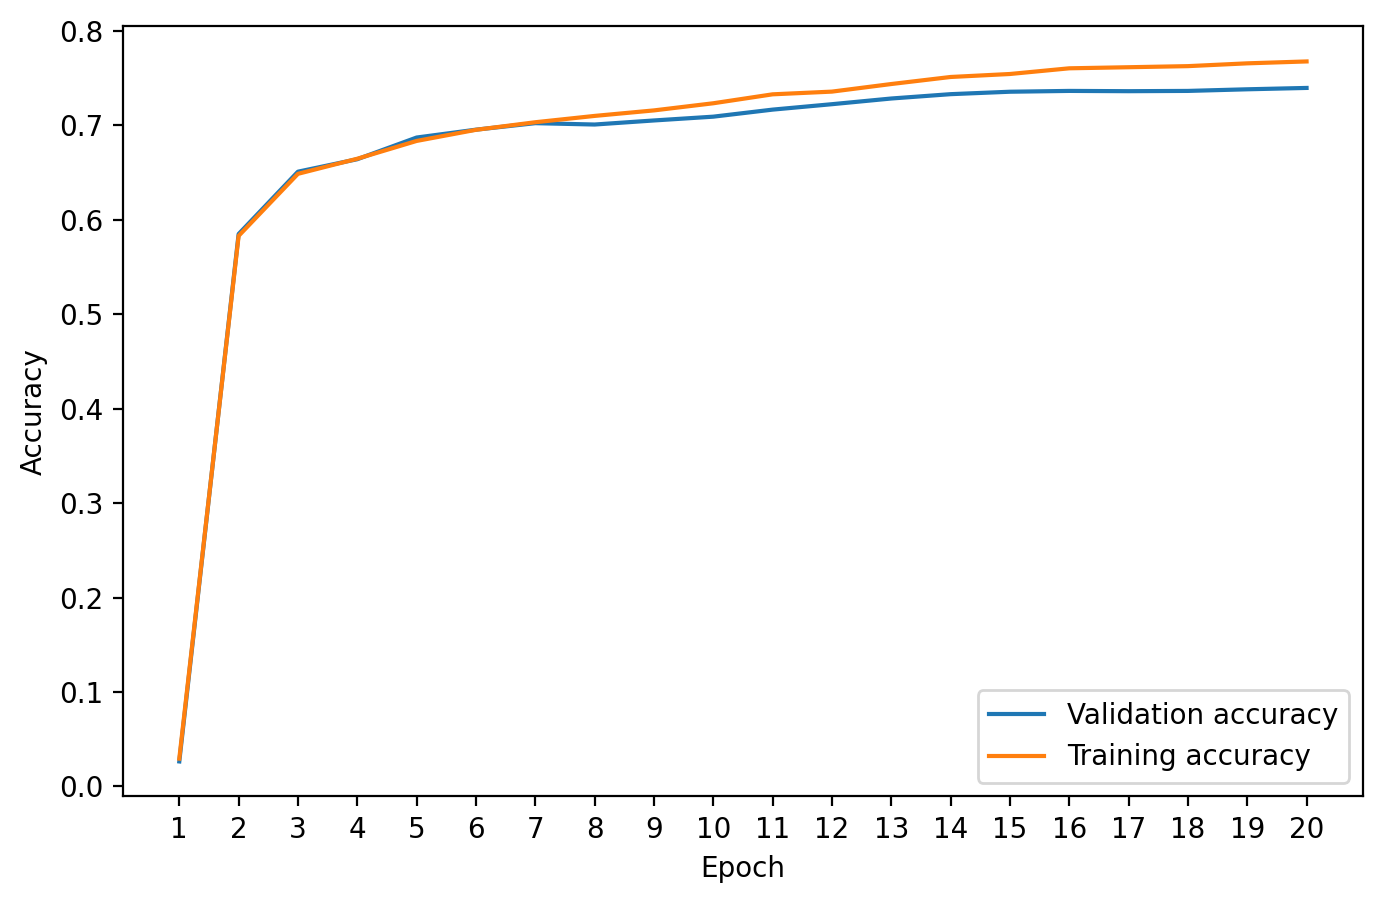

In [ ]:
fig = plt.figure(figsize=(8, 5))

# shift val acc, train acc, loss by 1 to align with epochs
x = np.arange(1, len(val_acc_values) + 1)

plt.plot(x, val_acc_values, label='Validation accuracy')
plt.plot(x, train_acc_values, label='Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# the plot should use interveval of 1 for x-axis
plt.xticks(np.arange(1, len(val_acc_values) + 1, 1.0))
plt.legend()
plt.show()

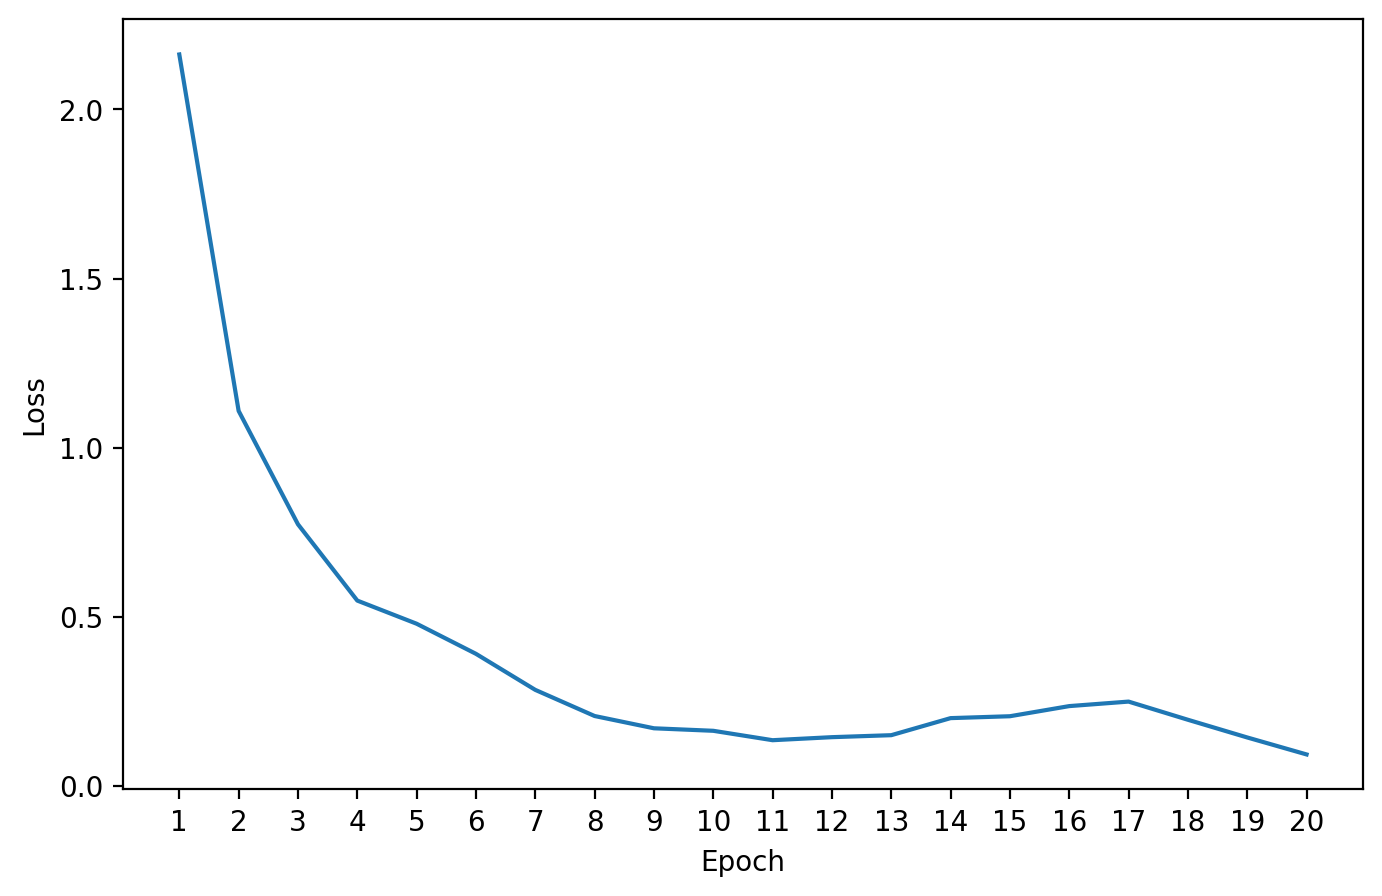

In [ ]:
fig = plt.figure(figsize=(8, 5))
plt.plot(x, loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1, len(val_acc_values) + 1, 1.0))
plt.show()

## Inference

In [ ]:
# visualize the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# pick a random name from the test set
name = 'Yamazaka Hitori'

# get its representation
name_tensor = lineToTensor(name)

for letter_i in range(name_tensor.shape[0]):
    X_val = tvm.nd.array(name_tensor[letter_i])
    _, _, _, _, _, _, h_t_val, y_pred = executor.run(
        feed_dict={
            X: X_val, 
            h_t_1: h_t_1_val,
            y_: y_val, 
            U: U_val,
            W: W_val,
            b1: b1_val,
            V: V_val,
            b2: b2_val
        })
    h_t_1_val.copyfrom(h_t_val)

y_pred_name_top3 = [idx_to_categ[i] for i in np.argsort(y_pred.asnumpy()[0])[-3:][::-1]]

print("Predicted class = %s" % str(y_pred_name_top3))

Predicted class = ['Russian', 'Italian', 'Japanese']


In [ ]:
# eval on test set
test_correct = 0
test_total = 0
for _, row in test_set.iterrows():
    category = row["country"]
    line = row["name"]
    category_tensor = np.zeros((1, n_categories), dtype=np.float32)
    category_tensor[0][categ_to_idx[category]] = 1
    line_tensor = lineToTensor(line)
    
    y_val.copyfrom(category_tensor)
    h_t_1_val = np.zeros((1, n_hidden), dtype=np.float32)
    h_t_1_val = tvm.nd.array(h_t_1_val)
    
    for letter_i in range(line_tensor.shape[0]):
        X_val = tvm.nd.array(line_tensor[letter_i])
        _, _, _, _, _, _, h_t_val, y_pred = executor.run(
            feed_dict={
                X: X_val, 
                h_t_1: h_t_1_val,
                y_: y_val, 
                U: U_val,
                W: W_val,
                b1: b1_val,
                V: V_val,
                b2: b2_val
            })
        h_t_1_val.copyfrom(h_t_val)
        
    test_correct += int(np.argmax(y_pred.asnumpy()[0]) == np.argmax(category_tensor[0]))
    test_total += 1
test_acc = test_correct / test_total
print("accuracy on test set: ", test_acc)

accuracy on test set:  0.7472022955523673
